# Numerical Optimization

In [225]:
# Importing required packages
import numpy as np
import pandas as pd         
import random
import cv2
from random import shuffle 
from tqdm import tqdm
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline
np.seterr(over = "ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'ignore', 'under': 'ignore'}

### Predicting Blood Donations

The following dataset is from a mobile blood donation vehicle in Taiwan. Objective is to predict whether or not a donor will give blood the next time the vehicle comes to campus. You can download data from [here](https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/).

Data is courtesy of Yeh, I-Cheng via the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center)

**Variable Description:**

* Months since Last Donation: this is the number of monthis since this donor's most recent donation.
* Number of Donations: this is the total number of donations that the donor has made.
* Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.
* Months since First Donation: this is the number of months since the donor's first donation.
* Made Donation in March 2007: this is the binary target variable, 1 if donated and 0 otherwise.

**Disclaimer:** I am not taking care of generalization error, only trying to optimize loss in the train data.

In [118]:
# Reading Blood donations data
train = pd.read_csv("../Warm Up_Predict Blood Donations/train.csv")
test = pd.read_csv("../Warm Up_Predict Blood Donations/test.csv")
train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


### Data Pre-processing

In [206]:
train.columns = ['ID'] + train.columns.tolist()[1:]
test.columns = ['ID'] + test.columns.tolist()[1:]
y = "Made Donation in March 2007"
feats = ["Months since Last Donation", "Number of Donations", "Total Volume Donated (c.c.)", "Months since First Donation"]
X_train = train.loc[:, train.columns != y]
X_train = X_train.loc[:, X_train.columns != "ID"]
Y = train[y]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

### Sigmoid Function

In [120]:
def prob(z):
    return 1/(1+np.exp(-z))

### Logistic Loss Function

In [121]:
def lnL(params, x_train, y_train):
    m = x_train.shape[0]
    n = x_train.shape[1]
    Xbeta = np.matmul(x_train, params)
    h = prob(Xbeta)
    h[h == 1] = 0.99
    h[h == 0] = 0.01
    result = -np.sum((y_train * np.log(h)) + ((1 - y_train) * np.log(1 - h)))/m
    return result, h

### To compute gradient for logistic loss function

In [122]:
def evaluate_gradient(loss_function, x_train, y_train, params):
    cost, scores = loss_function(params, x_train, y_train)
    dfbydx = np.matmul(y_train - scores, x_train)
    return dfbydx 

### Linear Search Function to decide learning rate

In [123]:
def LineSearch(f, params, g, g2, x_train, y_train, rho = 0.5, c = 1e-4):
    alphak = 0.5 # Start with big step size
    t = c*g2
    step0_sol, step0_scores = lnL(params, x_train, y_train)
    step1_sol, step1_scores = lnL(params + alphak*g, x_train, y_train)
    k = 1
    while (step1_sol - step0_sol) > alphak*t:
        alphak = alphak*rho
        if k == 10:
            break
        k = k + 1
    return alphak

### Main Function - It consists of few variants of gradient-based optimization

In [366]:
def XGD(n, params, f, grad, x_train, y_train, ls, learn_rate = 0.05, use_ls = True, epsilon = 1e-05, batch_size = 50, update_rule = None, plot = True):
    f0_sol, f0_scores = f(params, x_train, y_train)
    init_sol = np.append(params, f0_sol)
    final_res = pd.DataFrame(init_sol.reshape(-1, len(init_sol)))
    k = 0
    prev = np.inf
    m = x_train.shape[0]
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    x_train = x_train[ind]
    y_train = y_train[ind]
    nbatches = np.int(np.floor(m/batch_size))
    mbgd_train = np.array_split(x_train, nbatches)
    vt = 0
    gamma = 0.9
    cummulative_g = 0
    g_list = np.empty((0, x_train.shape[1]), float)
    delta_p_list = np.ones((x_train.shape[1])) * learn_rate
    g_adadelta = np.zeros(x_train.shape[1])
    beta_1 = 0.9
    beta_2 = 0.1
    m = 0
    v = 0
    t = 0
    for i in range(n):
        for j in range(nbatches):
            one_batch = mbgd_train[j]
            g = grad(f, x_train, y_train, params)
            if use_ls:
                g2 = np.matmul(g, g)
                alpha = ls(f, params, g, g2, x_train, y_train)
            else:
                alpha = learn_rate
            if update_rule is None:
                delta = alpha * g
                params = params + delta
            elif update_rule == "Momentum":
                vt = gamma*vt + alpha * g
                params = params + vt
            elif update_rule == "NAG":
                nag_g = grad(f, x_train, y_train, params-gamma*vt)
                vt = gamma*vt + alpha * nag_g
                params = params + vt
            elif update_rule == "Adagrad":
                cummulative_g = cummulative_g + np.square(g/max(g))
                G = np.diag(cummulative_g) + epsilon
                G = np.linalg.inv(np.sqrt(G))
                delta = alpha * np.matmul(G, g)
                params = params +  delta
            elif update_rule == "RMSprop":
                g_list = np.vstack((g_list, g/max(g)))
                exp_weights = np.asarray([np.exp(-x) for x in range(len(g_list))])
                exp_weights = exp_weights/sum(exp_weights)
                exp_weights = exp_weights[::-1]
                exp_avg = 0
                for i in range(len(exp_weights)):
                    exp_avg = exp_avg + exp_weights[i] * np.square(g_list[i])
                temp = exp_avg + epsilon
                temp = 1/np.sqrt(temp)
                delta_p = alpha*temp*g
                params = params +  delta_p
            elif update_rule == "Adadelta":
                g_list = np.vstack((g_list, g/max(g)))
                exp_weights = np.asarray([np.exp(-x) for x in range(len(g_list))])
                exp_weights = exp_weights/sum(exp_weights)
                exp_weights = exp_weights[::-1]
                exp_avg = 0
                exp_avg_delta = 0
                for i in range(len(exp_weights)):
                    exp_avg = exp_avg + exp_weights[i] * np.square(g_list[i])
                    exp_avg_delta = exp_avg_delta + exp_weights[i] * np.square(delta_p_list[i])
                temp = exp_avg + epsilon
                temp = np.sqrt(temp)
                temp_2 = exp_avg_delta + epsilon
                temp_2 = np.sqrt(temp_2)
                delta_p = (temp_2/temp)*g
                delta_p_list = np.vstack((delta_p_list, delta_p/max(delta_p)))
                params = params +  delta_p
            elif update_rule == "Adam":
                t = t + 1
                m = beta_1 * m + (1 - beta_1)*(g/max(g))
                v = beta_2 * v + (1 - beta_2)*np.square(g/max(g))
                m_hat = m/(1 - (beta_1**t))
                v_hat = v/(1 - (beta_2**t))
                delta = alpha * (m/(np.sqrt(v)+epsilon))
                #print(delta)
                params = params + delta
            fi_sol, fi_scores = f(params, x_train, y_train)
            final_res = pd.concat([final_res, pd.DataFrame([np.append(params, [fi_sol])])])
            if abs(prev - fi_sol) < epsilon:
                k = k + 1
            else:
                k = 0
            if k > 10:
                break
            prev = fi_sol
            sys.stdout.write("\r" + "Iteration no. {} | Batch no. {} | Cost {}".format(i, j, fi_sol))
    final_res.reset_index(drop = True,inplace = True)
    final_res.columns = feats + ['Cost']
    print("\nOptimal Cost: {}".format(min(final_res["Cost"])))
    if plot == True:
        plt.plot(final_res["Cost"])
        plt.ylabel('Iterations')
        plt.show()
    return final_res

### Setting Parameters

In [125]:
lb = -3
ub = 3
n = 100
params = [random.random() for x in range(X_train.shape[1])]
params = [lb + x*(ub-lb) for x in params]
params = np.asarray(params)

### Batch Gradient Descent

Iteration no. 99 | Batch no. 0 | Cost 0.646776896286

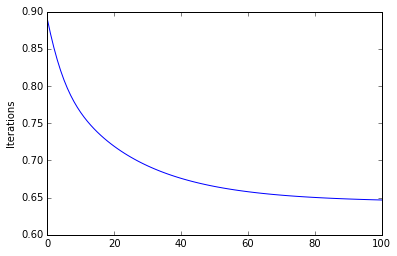

In [126]:
bs = X_train.shape[0] # Change this to 1 for Stochastic GD and number between 1 to X_train.shape[0] for Mini-Batch GD
results_bgd = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs)


### Stochastic Gradient Descent

Iteration no. 63 | Batch no. 10 | Cost 0.643785618612

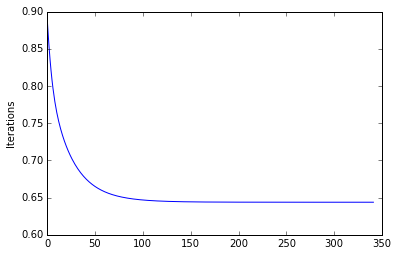

In [127]:
bs = 1
results_sgd = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs)

### Mini-Batch Gradient Descent

Iteration no. 83 | Batch no. 10 | Cost 0.643785618612

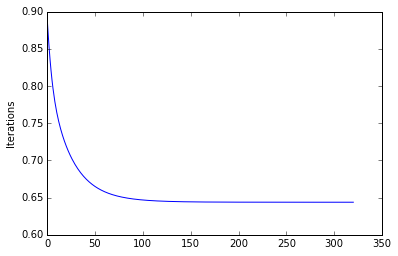

In [128]:
bs = 50
results_mbgd = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs)

### Comparing with Logistic Regression 

In [129]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y)
lr_cost, lr_scores = lnL(logisticRegr.coef_.tolist()[0], X_train, Y)
print("Logistic Regression Cost: {} \nBGD Cost: {} \nSGD Cost: {} \nMBGD Cost: {}".format(lr_cost, results_bgd["Cost"].min(), results_sgd["Cost"].min(), results_mbgd["Cost"].min()))

Logistic Regression Cost: 0.655546565452 
BGD Cost: 0.646776896286 
SGD Cost: 0.643783857057 
MBGD Cost: 0.643784586187


### Momentum

Iteration no. 95 | Batch no. 0 | Cost 0.643786254498

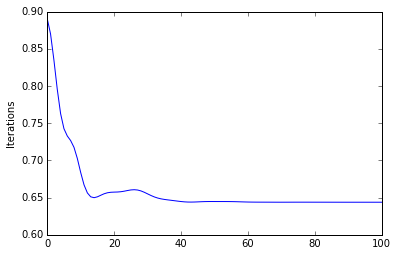

In [130]:
ur = "Momentum"
bs = X_train.shape[0]
results_momentum = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur)

### Nesterov accelerated gradient

Iteration no. 99 | Batch no. 0 | Cost 0.656565618632

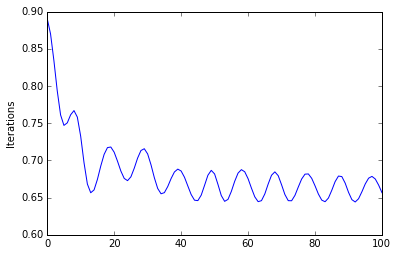

In [131]:
ur = "NAG"
bs = X_train.shape[0]
results_nag = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur)

### Adagrad

Iteration no. 99 | Batch no. 0 | Cost 0.644078568352

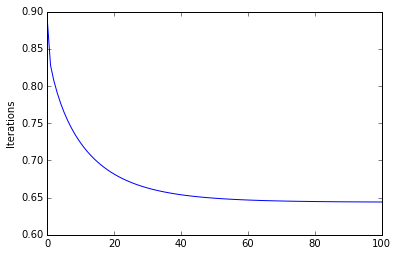

In [132]:
ur = "Adagrad"
bs = X_train.shape[0]
results_adagrad = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls=False, learn_rate=0.2)

### RMSprop

Iteration no. 217 | Batch no. 8 | Cost 0.6437995468857

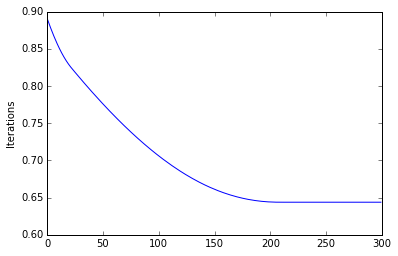

In [133]:
ur = "RMSprop"
bs = 50
results_rmsprop = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls=False, learn_rate=0.01)


### Adadelta

Iteration no. 93 | Batch no. 0 | Cost 0.643884175164

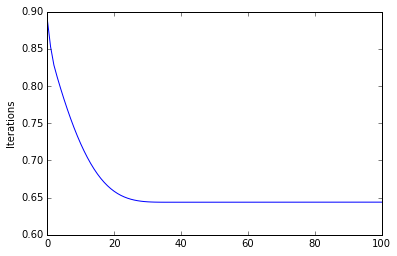

In [134]:
ur = "Adadelta"
bs = X_train.shape[0]
results_adadelta = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls = True, learn_rate = 0.1)


### Dogs vs. Cats example from Kaggle

In [147]:
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])

In [148]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [149]:
IMG_SIZE = 50
TRAIN_DIR = "train"
train_data = create_train_data()

100%|██████████| 25000/25000 [00:30<00:00, 824.11it/s]


### Data Pre-processing

In [233]:
train_features = [train_data[x][0].flatten() for x in range(len(train_data))]
train_features = pd.DataFrame(train_features)
train_y = [train_data[x][1].flatten() for x in range(len(train_data))]
train_y = pd.DataFrame(train_y)
train_features["is_dog"] = train_y.loc[:,1]

In [253]:
y = "is_dog"
feats = ["f_"+str(x) for x in range(train_features.shape[1]-1)]
train_features.columns = feats + [y]
X_train = train_features.loc[:, train_features.columns != y]
Y = train_features[y]
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

### Setting Parameters

In [285]:
lb = -3
ub = 3
n = 100
params = [random.random() for x in range(X_train.shape[1])]
params = [lb + x*(ub-lb) for x in params]
params = np.asarray(params)

### Batch Gradient Descent

Iteration no. 99 | Batch no. 0 | Cost 2.24644315393
Optimal Cost: 2.15909598736


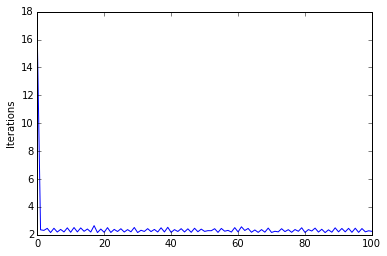

In [323]:
bs = X_train.shape[0] # Change this to 1 for Stochastic GD and number between 1 to X_train.shape[0] for Mini-Batch GD
results_bgd = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs)

### Mini-Batch Gradient Descent

Iteration no. 9 | Batch no. 49 | Cost 2.19598794537

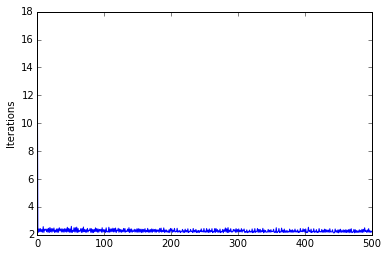

In [259]:
bs = 500 # Change this to 1 for Stochastic GD and number between 1 to X_train.shape[0] for Mini-Batch GD
results_bgd = XGD(10, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs)

### Momentum

Iteration no. 99 | Batch no. 0 | Cost 2.11620737381
Optimal Cost: 2.00121187731


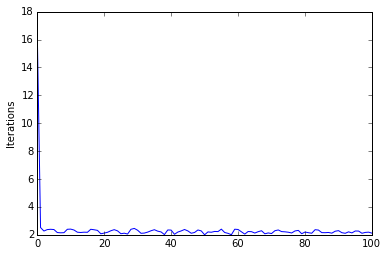

In [269]:
ur = "Momentum"
bs = X_train.shape[0]
results_momentum = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur)

### Nesterov accelerated gradient

Iteration no. 99 | Batch no. 0 | Cost 2.37998016158
Optimal Cost: 2.07270773418


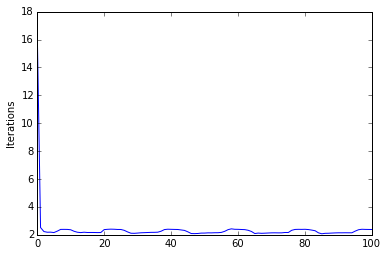

In [268]:
ur = "NAG"
bs = X_train.shape[0]
results_nag = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur)

### Adagrad

Iteration no. 99 | Batch no. 0 | Cost 2.73011980379
Optimal Cost: 2.38555381336


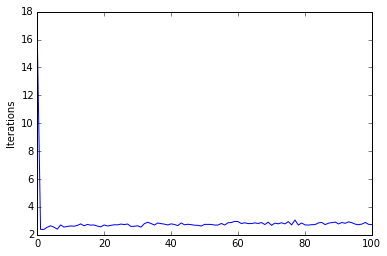

In [324]:
ur = "Adagrad"
bs = X_train.shape[0]
results_adagrad = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls = False, learn_rate = 0.1)

### RMSprop

Iteration no. 99 | Batch no. 0 | Cost 2.26284104793
Optimal Cost: 2.19833846052


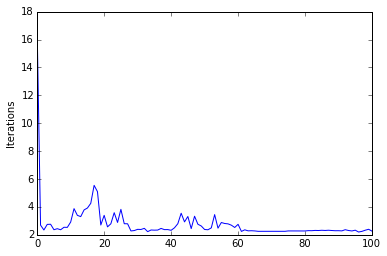

In [316]:
ur = "RMSprop"
bs = X_train.shape[0]
results_rmsprop = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls=False, learn_rate=0.1)


### Adadelta

Iteration no. 99 | Batch no. 0 | Cost 2.30558398473
Optimal Cost: 1.99529561564


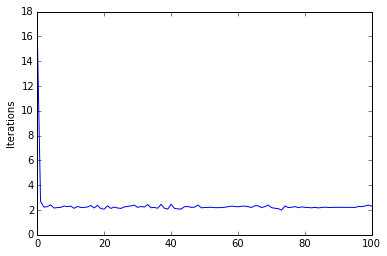

In [320]:
ur = "Adadelta"
bs = X_train.shape[0]
results_adadelta = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls = True, learn_rate = 0.1)


Iteration no. 99 | Batch no. 0 | Cost 3.09809500019
Optimal Cost: 2.77663939332


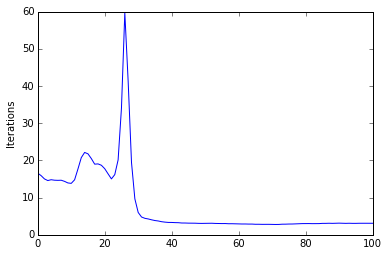

In [367]:
ur = "Adam"
bs = X_train.shape[0]
results_adadelta = XGD(n, params, lnL, evaluate_gradient, X_train, Y, LineSearch, batch_size = bs, update_rule = ur, use_ls = False, learn_rate = 0.1)
